In [2]:
info_url = e.get_info_url(response="csv")
e_info = pd.read_csv(info_url)

start = e_info.loc[e_info["Attribute Name"] == "time_coverage_start", "Value"].item()
end   = e_info.loc[e_info["Attribute Name"] == "time_coverage_end", "Value"].item()

print("Time coverage:", start, "to", end)


NameError: name 'e' is not defined

In [24]:
e.constraints["time>="] = "2020-01-01T00:00:00Z"
e.constraints["time<="] = "2020-01-01T00:00:00Z"


In [3]:
from erddapy import ERDDAP
import pandas as pd

# Connect
e = ERDDAP(
    server="https://erddap.emodnet.eu/erddap",
    protocol="griddap"
)

e.dataset_id = "GLODAPv2_2016b_CMEMS"
e.griddap_initialize()

# Inspect coverage
info_url = e.get_info_url(response="csv")
e_info = pd.read_csv(info_url)

start = e_info.loc[e_info["Attribute Name"] == "time_coverage_start", "Value"].item()
end   = e_info.loc[e_info["Attribute Name"] == "time_coverage_end", "Value"].item()
minlat = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lat_min", "Value"].item())
maxlat = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lat_max", "Value"].item())
minlon = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lon_min", "Value"].item())
maxlon = float(e_info.loc[e_info["Attribute Name"] == "geospatial_lon_max", "Value"].item())

print("Dataset covers:", start, "to", end)
print(f"Latitude range: {minlat} to {maxlat}")
print(f"Longitude range: {minlon} to {maxlon}")

# Variables
e.variables = ["TCO2", "TAlk", "pHts25p0"]

# Use valid coverage for constraints
e.constraints["time>="] = start
e.constraints["time<="] = end
e.constraints["latitude>="] = minlat
e.constraints["latitude<="] = maxlat
e.constraints["longitude>="] = minlon
e.constraints["longitude<="] = maxlon

# Fetch
ds = e.to_xarray()
print(ds)
print(ds["TCO2"].isel(time=0).values)   # first slice


Dataset covers: 2020-01-01T00:00:00Z to 2020-01-01T00:00:00Z
Latitude range: -89.5 to 89.5
Longitude range: 20.5 to 379.5
<xarray.Dataset> Size: 51MB
Dimensions:    (time: 1, depth: 33, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 8B 2020-01-01
  * depth      (depth) float64 264B 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 3kB 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
Data variables:
    TCO2       (time, depth, latitude, longitude) float64 17MB ...
    TAlk       (time, depth, latitude, longitude) float64 17MB ...
    pHts25p0   (time, depth, latitude, longitude) float64 17MB ...
Attributes: (12/54)
    area:                          Global Ocean
    author:                        GLODAP and Copernicus data provider
    cdm_data_type:                 Grid
    citation:                      These data were collected and made freely ...

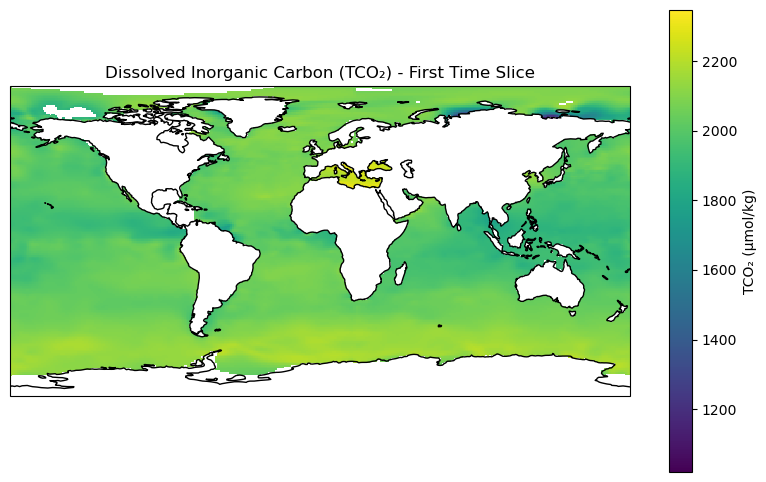

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select first time slice, surface depth (depth=0)
tco2_slice = ds["TCO2"].isel(time=0, depth=0)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tco2_slice.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    cbar_kwargs={"label": "TCO₂ (µmol/kg)"}
)
ax.coastlines()
ax.set_title("Dissolved Inorganic Carbon (TCO₂) - First Time Slice")
plt.savefig("TCO2_First_Slice.png", dpi=300, bbox_inches="tight")
plt.show()


## Visualization of how much dissolved inorganic carbon (DIC) is present in different parts of the global surface ocean, at one time snapshot.

High concentrations (yellow/green) → typically in the North Atlantic and some equatorial upwelling zones, where deep carbon-rich water mixes upward.

Lower concentrations (purple/blue) → in warmer surface waters, especially subtropical gyres, where CO₂ is outgassed to the atmosphere.

### Carbon data becomes a parallel data source, aligned in time & space with your other environmental variables.
### Once harmonized, it feeds into both analysis and visualization stages.